In [9]:
def digitize_model(rc_int, t_int, t):
    """
    Sample a simple layered reflectivity model

    Usage:
    ------
    rc = digitize_model(rc, t_int, t)

    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    """

    import numpy as np

    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)

    rc = list(np.zeros(nsamp, dtype='float'))
    lyr = 0

    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1

        if lyr > nint:
            break

    return rc

In [1]:
"""
Python script to generate a synthetic angle gather from a 3-layer property model
to examine pre-stack tuning effects.
Created by:    Wes Hamlyn
Create Date:   19-Aug-2014
Last Mod:      5-Feb-2015
               -addition of bandpass wavelet

This script is provided without warranty of any kind.
"""

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

###########################################################
#
#       FUNCTIONS DEFINITIONS
#





def vshale_from_gr(df):
    """
    Creates Clavier, Larionov old, Larionov new, Steiber VSH
    """    
    GR_min = df.GR.min()
    GR_max = df.GR.max()
    df.loc[:, 'IGR'] = (df.GR - GR_min) / (GR_max - GR_min)
    df.loc[:, 'VSH_clavier'] = 1.7 - ((3.38 - (df.IGR + 0.7)**2)**0.5)
    df.loc[:, 'VSH_larionovO'] = 0.33 * (2**(2*df.IGR)-1)
    df.loc[:, 'VSH_steiber'] = df.IGR / (3 - 2*df.IGR)
    df.loc[:, 'VSH_larionovT'] = 0.083*(2**(3.7*df.IGR)-1)
    # Pick one to be "main" VSH
    df['VSH'] = df.VSH_larionovO
    return df


def vrh(volumes,k,mu):
    f = np.array(volumes).T
    k = np.resize(np.array(k),np.shape(f))
    mu = np.resize(np.array(mu),np.shape(f))

    k_u = np.sum(f*k, axis=1)
    k_l = 1. / np.sum(f/k, axis=1)
    mu_u = np.sum(f*mu, axis=1)
    mu_l = 1. / np.sum(f/mu, axis=1)
    k0 = (k_u+k_l) / 2.
    mu0 = (mu_u+mu_l) / 2.
    return k_u, k_l, mu_u, mu_l, k0, mu0


def plot_vawig(axhdl, data, t, excursion):
    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])

    for i in range(0, ntrc):
        tbuf = excursion * data[i, :] / np.max(np.abs(data)) + i

        tbuf = np.hstack([i, tbuf, i])

        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf > i, facecolor=[0.6, 0.6, 1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf < i, facecolor=[1.0, 0.7, 0.7], linewidth=0)

    axhdl.set_xlim((-excursion, ntrc + excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()


def ricker(cfreq, phase, dt, wvlt_length):
    """
    Calculate a zero-phase ricker wavelet

    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)

    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    """

    import numpy as np
    import scipy.signal as signal

    nsamp = int(wvlt_length / dt + 1)
    t_max = wvlt_length * 0.5
    t_min = -t_max

    # t = np.arange(t_min, t_max, dt)

    t = np.linspace(-wvlt_length / 2, (wvlt_length - dt) / 2, int(wvlt_length / dt))
    wvlt = (1.0 - 2.0 * (np.pi ** 2) * (cfreq ** 2) * (t ** 2)) * np.exp(-(np.pi ** 2) * (cfreq ** 2) * (t ** 2))

    if phase != 0:
        phase = phase * np.pi / 180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase) * wvlt - np.sin(phase) * wvlth

    return t, wvlt


def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    """
    Calculate a trapezoidal bandpass wavelet

    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)

    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    """

    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift

    nsamp = int(wvlt_length / dt + 1)

    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq * 0.0
    pspec = freq * 0.0

    # Calculate slope and y-int for low frequency ramp
    M1 = 1 / (f2 - f1)
    b1 = -M1 * f1

    # Calculate slop and y-int for high frequency ramp
    M2 = -1 / (f4 - f3)
    b2 = -M2 * f4

    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)

    # Build LF ramp
    idx = np.nonzero((np.abs(freq) >= f1) & (np.abs(freq) < f2))
    filt[idx] = M1 * np.abs(freq)[idx] + b1

    # Build central filter flat
    idx = np.nonzero((np.abs(freq) >= f2) & (np.abs(freq) <= f3))
    filt[idx] = 1.0

    # Build HF ramp
    idx = np.nonzero((np.abs(freq) > f3) & (np.abs(freq) <= f4))
    filt[idx] = M2 * np.abs(freq)[idx] + b2

    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2 * np.exp(np.zeros(filt2.shape) * 1j)

    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt / np.max(np.abs(wvlt))  # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length * 0.5, wvlt_length * 0.5, nsamp)

    # Apply phase rotation if desired
    if phase != 0:
        phase = phase * np.pi / 180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase) * wvlt - np.sin(phase) * wvlth

    return t, wvlt


def calc_times(z_int, vp_mod):
    """
    Calculate two-way travel time through a layered model

    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)

    """

    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i] / vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i] - z_int[i - 1]
            zdiff = zdiff * 2.0  # multiply by 2 for two-way traveltimes
            tbuf = zdiff / vp_mod[i] + t_int[i - 1]
            tbuf = tbuf
            t_int.append(tbuf)

    return t_int





def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    """
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.

    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)

    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    """

    import math

    # Cast inputs to floats
    vp1 = float(vp1)
    vp2 = float(vp2)
    vs1 = float(vs1)
    vs2 = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)

    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)  # Convert theta1 to radians
    p = ray_param(vp1, math.degrees(theta1))  # Ray parameter
    theta2 = math.asin(p * vp2);  # Transmission angle of P-wave
    phi1 = math.asin(p * vs1);  # Reflection angle of converted S-wave
    phi2 = math.asin(p * vs2);  # Transmission angle of converted S-wave

    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)], \
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)], \
        [2 * rho1 * vs1 * math.sin(phi1) * math.cos(theta1), rho1 * vs1 * (1 - 2 * math.sin(phi1) ** 2), \
         2 * rho2 * vs2 * math.sin(phi2) * math.cos(theta2), rho2 * vs2 * (1 - 2 * math.sin(phi2) ** 2)], \
        [-rho1 * vp1 * (1 - 2 * math.sin(phi1) ** 2), rho1 * vs1 * math.sin(2 * phi1), \
         rho2 * vp2 * (1 - 2 * math.sin(phi2) ** 2), -rho2 * vs2 * math.sin(2 * phi2)]
    ], dtype='float')

    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)], \
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)], \
        [2 * rho1 * vs1 * math.sin(phi1) * math.cos(theta1), rho1 * vs1 * (1 - 2 * math.sin(phi1) ** 2), \
         2 * rho2 * vs2 * math.sin(phi2) * math.cos(theta2), rho2 * vs2 * (1 - 2 * math.sin(phi2) ** 2)], \
        [rho1 * vp1 * (1 - 2 * math.sin(phi1) ** 2), -rho1 * vs1 * math.sin(2 * phi1), \
         -rho2 * vp2 * (1 - 2 * math.sin(phi2) ** 2), rho2 * vs2 * math.sin(2 * phi2)] \
        ], dtype='float')

    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);

    return R


def ray_param(v, theta):
    """
    Calculates the ray parameter p

    Usage:
    ------
        p = ray_param(v, theta)

    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)

    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    """

    import math

    # Cast inputs to floats
    theta = float(theta)
    v = float(v)

    p = math.sin(math.radians(theta)) / v  # ray parameter calculation

    return p

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from packages.functions import * # vrh, softsand, stiffsand, hertzmindlin, vels, rpt
# are the vrh inputs vectors?

well1 = pd.read_csv("./data/well_1.txt", header=None, skiprows=1, sep="  ", usecols=[0,4,8,11])
well1.rename(columns={0:"DEPTH", 4:"VP", 8:"DEN", 11:"GR"}, inplace=True)
well1.head()

well2 = pd.read_csv("./data/well_2.txt", header=None, skiprows=1, sep="  ", usecols=[0,3,6,9,11,14])
well2.rename(columns={0:"DEPTH", 3:"VP", 6:"VS", 9:"DEN", 11:"GR", 14:"NPHI" }, inplace=True)
well2.head()

well3 = pd.read_csv("./data/well_3.txt", header=None, skiprows=1, sep=" ", usecols=[5,13,17,24]) # sep="  ")#, 
well3.rename(columns={5:"DEPTH", 13:"VP", 17:"DEN", 24:"GR"}, inplace=True)
well3.head()

well4 = pd.read_csv("./data/well_4.txt", header=None, skiprows=1, sep=" ", usecols=[4,12,20,27]) # sep="  ")#, 
well4.rename(columns={4:"DEPTH", 12:"VP", 20:"DEN", 27:"GR"}, inplace=True)
well4.head()

well5 = pd.read_csv("./data/well_5.txt", header=None, skiprows=1, sep=" ", usecols=[3,6,9,12,15]) # sep="  ")#, 
well5.rename(columns={3:"DEPTH", 6:"t_p", 9:"t_s", 12:"GR", 15:"DEN"}, inplace=True)
well5.head()

well2["PHIE"] = (2.65- well2.DEN)/(2.65 - 1.05)
well2["VSH"] = (well2.GR - 40) / (140-40)
well2["IP"] = well2.VP*1000 * well2.DEN
well2["IS"] = well2.VS*1000 * well2.DEN
well2["VPVS"] = well2.VP / well2.VS
well2['K'] = well2.DEN*(well2.VP**2 - 4/3.*(well2.VS)**2)

facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
colors = ["black", "brown", "green", "purple", "orange", "magenta"]

conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["FACIES"] = np.select(conditions, facies)

In [3]:
df = well2.copy()

In [4]:
###########################################################
#
#       DEFINE MODELING PARAMETERS HERE
#

vp_mod = list(df.VP*1000)
vs_mod = list(df.VS*1000)
rho_mod = list(df.DEN)
# vp_mod = list(df.VP_FRMG)
# vs_mod = list(df.VS_FRMG)
# rho_mod = list(df.RHO_FRMG)
z_int = list(df.DEPTH)#[:-1])
# twt_mod = list(df.TWT/1000)

#   Angle range for incident rays
theta1_min = 0.0  # best to leave this set to zero
theta1_max = 40.0
theta1_step = 1.0

#   Wavelet Parameters
wvlt_type = 'bandpass'  # Valid values: 'ricker' or 'bandpass'
# wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length = 0.128  # Wavelet length in seconds
wvlt_phase = 0.0  # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 = 5.0  # Bandpass wavelet low truncation frequency
f2 = 10.0  # Bandpass wavelet low cut frequency
f3 = 60.0  # Bandpass wavelet high cut frequency
f4 = 75.0  # Bandpass wavelet high truncation frequency

#   Trace Parameters
tmin = 0.0
tmax = 2.0
dt = 0.00001  # changing this from 0.0001 can affect the display quality

In [5]:
##########################################################
#
#       COMPUTATIONS HAPPEN BELOW HERE
#


#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int((theta1_max - theta1_min) / theta1_step + 1)

In [6]:
print(f"nlayers: {nlayers}")
print(f"nint: {nint}")
print(f"nangles: {nangles}")

nlayers: 4117
nint: 4116
nangles: 41


In [7]:
#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

rows, cols = (nangles, len(vp_mod) - 1)
rc_zoep_pp = [[0] * cols] * rows

theta1 = []
for i in range(0, nangles):
    theta1_buf = i * theta1_step + theta1_min
    rc_zoep_pp_tmp = []
    for j in range(0, len(vp_mod) - 1):
        rc_buf = rc_zoep(vp_mod[j], vs_mod[j], rho_mod[j], vp_mod[j + 1], vs_mod[j + 1], rho_mod[j + 1], theta1_buf)
        rc_zoep_pp_tmp.append(rc_buf[0, 0])
    rc_zoep_pp[i] = rc_zoep_pp_tmp

In [21]:
#   Define time sample vector for output model & traces
nsamp = int((tmax - tmin) / dt) + 1
t = []
for i in range(0, nsamp):
    t.append(np.round((i * dt),4))
    

# print(f"nsamp: {nsamp}")
print(f"t: {t[-1]}")

t: 2.0


In [11]:
syn_zoep_pp = []
lyr_times = []
# print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    # p = ray_param(vp_mod[0], angle)
    # angle2 = math.degrees(math.asin(p*vp_mod[1]))
    # dz_app = thickness/math.cos(math.radians(angle2))

    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    #t_int = twt_mod[:-1]
    
    ## IF t[i] is never >= tint[i] then following error.  t/tint MUST be in seconds!!
    # Traceback (most recent call last):
    #  line 459, in <module>
    # lines.append(syn_zoep_pp[j, idx[j]])
    # IndexError: index 20433 is out of bounds for axis 1 with size 20001
    
    lyr_times.append(t_int)

    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    # print("Calculated angle %i" % (angle))

In [12]:
t[:5], t_int[:5]

([0.0, 0.0, 0.0, 0.0, 0.0],
 [0.8773490216586045,
  0.8774817338108228,
  0.8776148110025799,
  0.8777486419575743,
  0.8778833899681843])

In [14]:
np.max(rc), np.min(rc)

(0.22304240855187907, -0.5559977320866873)

In [15]:
#    Convert data arrays from lists/tuples to numpy arrays
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)

#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times / dt), dtype='int32')

In [16]:
lyr_indicies = []
for i in range(0, nint):
    lyr_indicies.append(lyr_indx[:, i])

[ntrc, nsamp] = syn_zoep_pp.shape  # eg: 41 traces, 5001 samples

lines = []
for i in range(0, nint):
    idx = lyr_indx[:, i]
    for j in range(0, 41):
        lines.append(syn_zoep_pp[j, idx[j]])

lines = np.reshape(np.array(lines), (nint, nangles))

In [17]:
#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:, 0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(lines[0])
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc, 1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc))) ** 2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

print('\n\n')
print('  Method       NI         GRAD')
print('---------------------------------')
print(' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
print(' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))




  Method       NI         GRAD
---------------------------------
 Zoeppritz    0.01239    -0.05114
 Convolved   0.06668    -0.01573


In [18]:
#   Create a "digital" time domain version of the input property model for
#   easy plotting and comparison with the time synthetic traces

print(f"t.shape: {t.shape}")
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

for i in range(0, nlayers):
    if i == 0:
        vp_dig[0:lyr_indicies[i][0]] = vp_mod[i]
    if 0 < i < nint:
        vp_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = vp_mod[i]
    vp_dig[lyr_indicies[i - 1][0]:] = vp_mod[i]

for i in range(0, nlayers):
    if i == 0:
        vs_dig[0:lyr_indicies[i][0]] = vs_mod[i]
    if 0 < i < nint:
        vs_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = vs_mod[i]
    vs_dig[lyr_indicies[i - 1][0]:] = vs_mod[i]

for i in range(0, nlayers):
    if i == 0:
        rho_dig[0:lyr_indicies[i][0]] = rho_mod[i]
    if 0 < i < nint:
        rho_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = rho_mod[i]
    rho_dig[lyr_indicies[i - 1][0]:] = rho_mod[i]

t.shape: (200000,)


In [19]:
#   Plotting Display Parameters
min_plot_time = 0.8
max_plot_time = 1.5
excursion = 2

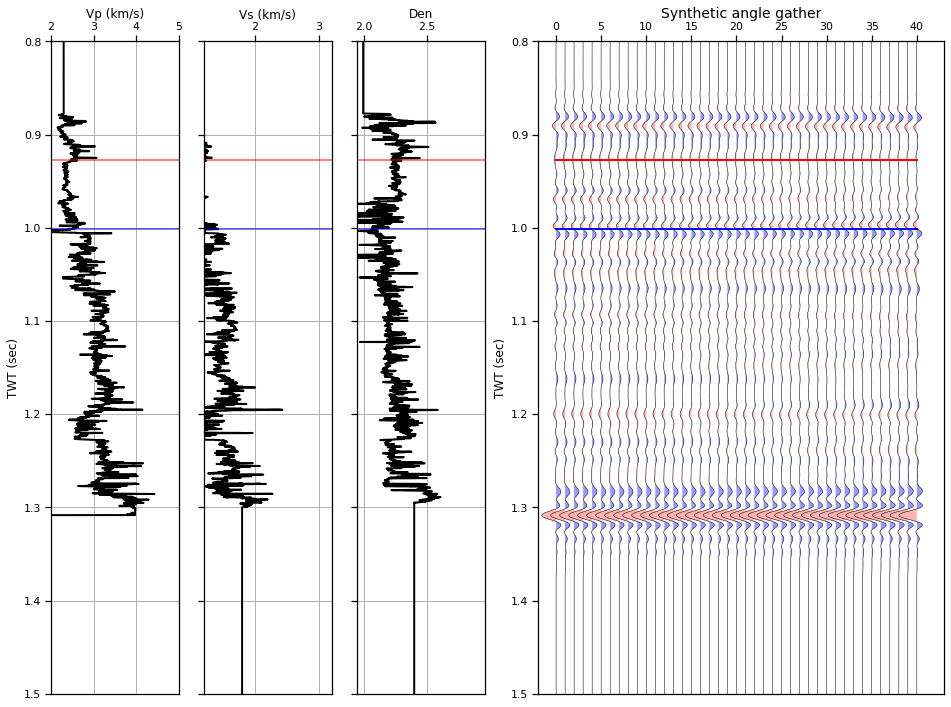

In [20]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')

#   Plot log curves in two-way time
ax0a = fig.add_subplot(161)
l_vp_dig, = ax0a.plot(vp_dig / 1000, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time, max_plot_time))
ax0a.set_xlim(2.0, 5.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(162)
l_vs_dig, = ax0b.plot(vs_dig / 1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time, max_plot_time))
ax0b.set_xlim(1.2, 3.2)
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(163)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time, max_plot_time))
ax0c.set_xlim(1.95, 2.95)
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0c.grid()


#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(122)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
ax1.set_ylim((min_plot_time, max_plot_time))
l_int1, = ax1.plot(lyr_times[:, 980], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:, 393], color='red', lw=2)

# plt.legend([l_int1, l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather'
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')



#   Save the plot
plt.savefig('figure_2.png')

#   Display the plot
plt.show()